In [79]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as pl
from sklearn.preprocessing import StandardScaler, scale
from seaborn import heatmap
from matplotlib import rcParams
from cmocean import cm
from theano import tensor as tt

In [11]:
% matplotlib inline

In [51]:
rcParams['xtick.labelsize'] = 14
rcParams['ytick.labelsize'] = 14
rcParams['font.size'] = 16

In [102]:
dfLabels = pd.read_pickle('../PklJar/DFLABELS.pkl')
dfFeatures = pd.read_pickle('../PklJar/DFFEATURES.pkl')

In [4]:
dfLabels.head(2)

,NUM_ANIMALS,SPECIES_Delphinus delphis,SPECIES_Globicephala melas,SPECIES_Grampus griseus,SPECIES_Lagenorhynchus acutus,SPECIES_Stenella coeruleoalba,SPECIES_Tursiops truncatus,CONDITION_CODE_1,CONDITION_CODE_2,CONDITION_CODE_3,CONDITION_CODE_4,CONDITION_CODE_6
1999-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1999-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [103]:
dfFeatures.head(2)

,Ddelph_count,Lageno_count,FRDH,FRDV,OTTH,OTTV,Kp_index,Sunspot_No,Dst_index,AE_index,...,Pred_med,ampDiff_med,vel_med,move_med,EasterlyWS,SoutherlyWS,WTMP,WVHT,APD,DPD
1999-01-01,0.0,0.0,20999.987708,49201.519653,17459.028474,53549.040000,15.75,89.0,-3.333333,94.333333,...,1.435,3.470,0.555200,3.58,-8.369086,-1.962736,5.629167,0.782083,4.260000,7.372083
1999-01-02,0.0,0.0,20995.609097,49202.668125,17455.841440,53548.428889,17.75,94.0,-7.458333,139.875000,...,1.435,0.165,0.012217,3.53,-10.358338,2.124278,5.470833,1.029167,3.723333,4.049167


In [6]:
dfFeatures.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5844 entries, 1999-01-01 to 2014-12-31
Freq: D
Data columns (total 34 columns):
Ddelph_count           5844 non-null float64
Lageno_count           5844 non-null float64
FRDH                   5836 non-null float64
FRDV                   5824 non-null float64
OTTH                   5479 non-null float64
OTTV                   5465 non-null float64
Kp_index               5844 non-null float64
Sunspot_No             5844 non-null float64
Dst_index              5844 non-null float64
AE_index               5844 non-null float64
Proton_flux_gt30MeV    5352 non-null float64
Proton_flux_gt60MeV    5352 non-null float64
Pred_min               5844 non-null float64
ampDiff_min            5844 non-null float64
vel_min                5844 non-null float64
move_min               5844 non-null float64
Pred_max               5844 non-null float64
ampDiff_max            5844 non-null float64
vel_max                5844 non-null float64
move_max    

In [19]:
y_all_obs = dfAll

In [104]:
dfFeatures.drop(['Proton_flux_gt30MeV', 'Proton_flux_gt60MeV'], axis=1, inplace=True)
dfFeatures.drop(['ampDiff_min','vel_min', 'vel_min', 'move_min',
                 'ampDiff_max','vel_max', 'vel_max', 'move_max',
                 'ampDiff_med','vel_med', 'vel_med', 'move_med', 'Pred_med',
                 'ampDiff_std','vel_std', 'vel_std', 'move_std', 'Pred_std'
                ], axis=1, inplace=True)

In [ ]:
dfFeatures['Pred_min'] = dfFeatures['Pred_min'] * -1

In [41]:
dfClFeats = dfFeatures.dropna()

In [42]:
dfClLbls = dfLabels.loc[dfClFeats.index,:]

In [88]:
label_list = ['NUM_ANIMALS', 'SPECIES_Delphinus delphis', 'SPECIES_Lagenorhynchus acutus']
X = dfClFeats.as_matrix()
sc = StandardScaler()
X_s = sc.fit_transform(X)
X_all_sp_s = X_s[:,2:]
y_num_obs = dfClLbls.as_matrix(columns=label_list)

In [45]:
X.shape

(4968, 18)

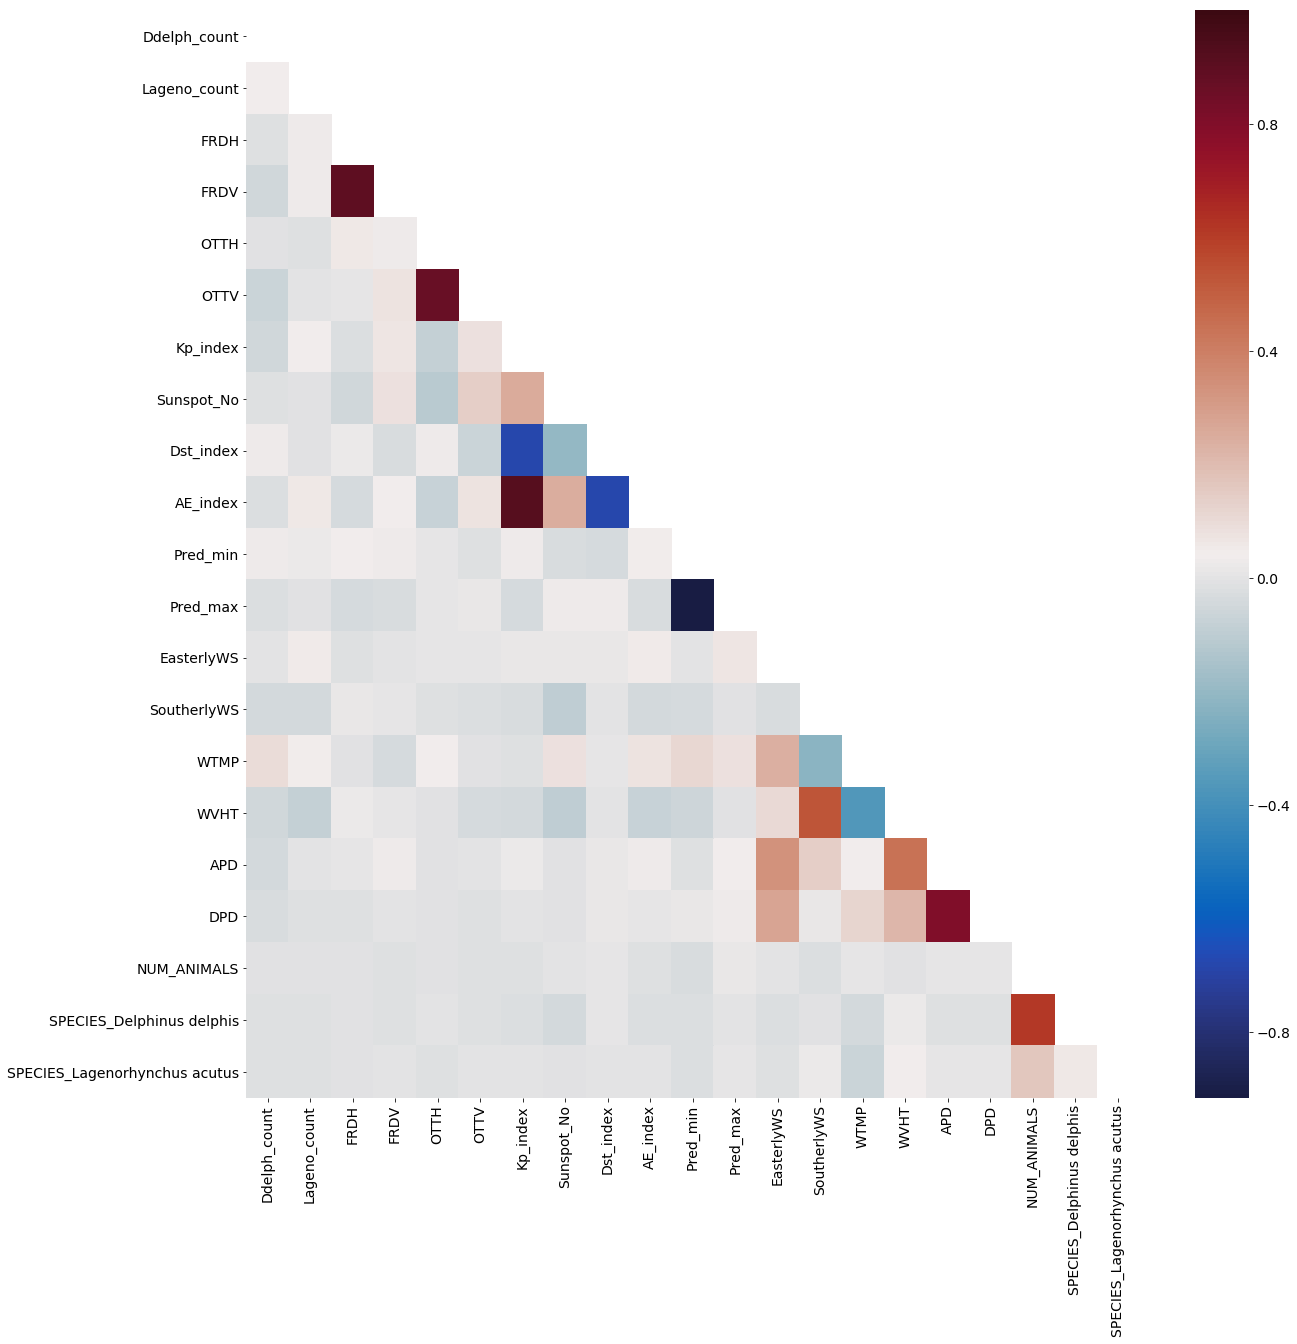

In [98]:
f, ax= pl.subplots(figsize=(20, 20))
heatmap(pd.DataFrame(np.column_stack((X_s, y_num_obs)),
                     columns=dfClFeats.columns.tolist() + label_list).corr(),
        mask=np.triu(np.ones((21,21))),ax=ax, cmap=cm.balance)

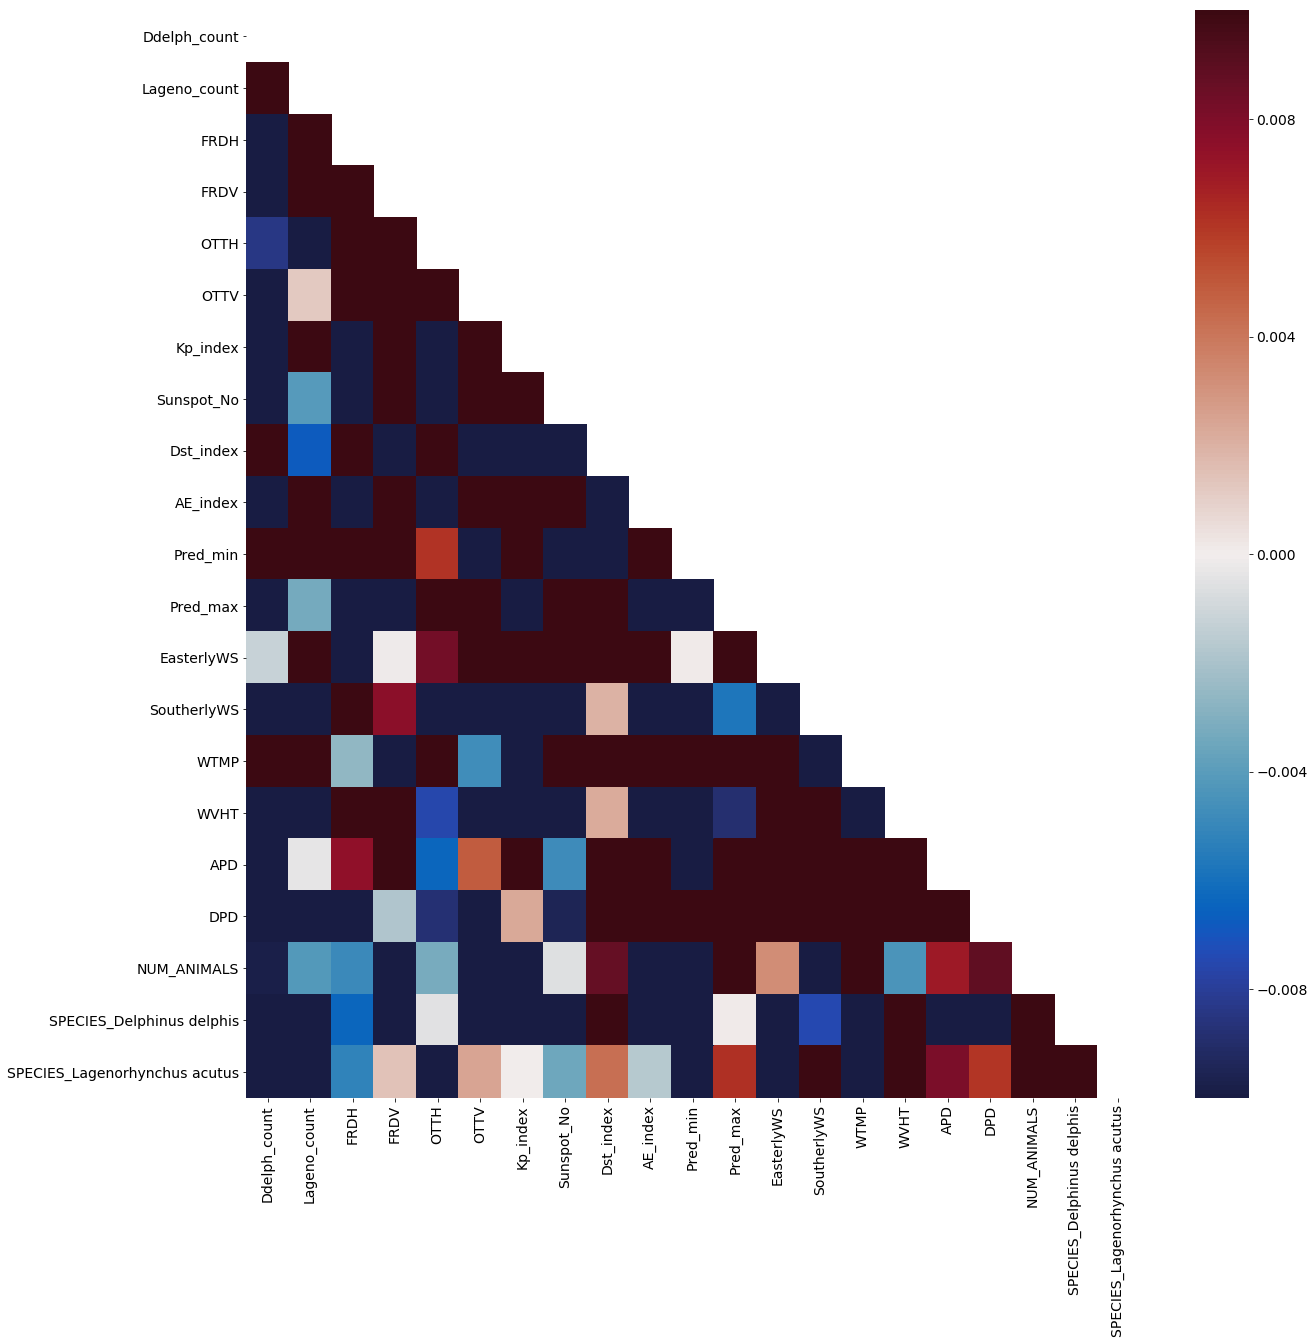

In [76]:
f, ax= pl.subplots(figsize=(20, 20))
heatmap(pd.DataFrame(np.column_stack((X_s, y_num_obs)),
                     columns=dfClFeats.columns.tolist() + label_list).corr(),
        mask=np.triu(np.ones((21,21))),ax=ax, cmap=cm.balance, vmin=-0.01, vmax=0.01, )

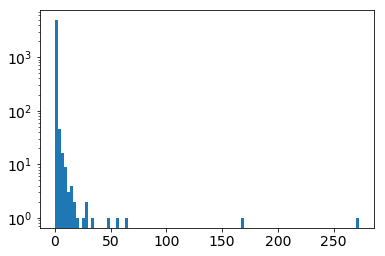

In [70]:
pl.hist(dfClLbls.NUM_ANIMALS, log=True, bins=100);

In [71]:
dfClLbls.NUM_ANIMALS.max()

273.0

(4968, 18)

In [74]:
y_all_obs = dfClLbls.NUM_ANIMALS.values
y_Lag_obs = dfClLbls['SPECIES_Lagenorhynchus acutus'].values
y_Del_obs = dfClLbls['SPECIES_Delphinus delphis'].values

In [129]:
with pm.Model() as m0:
    intercept = pm.Normal('intercept', 0, 100)
    mu = tt.exp(intercept)
    y_pred = pm.Poisson('y_pred', mu=mu, observed=y_all_obs)
    start = pm.find_MAP()
    trace_m0 = pm.sample(10000, start=start)

logp = -8,437.1, ||grad|| = 3,652: 100%|██████████| 8/8 [00:00<00:00, 665.14it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 10500/10500 [00:10<00:00, 1034.59it/s]


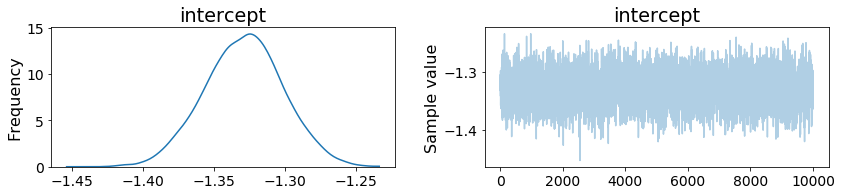

In [133]:
pm.traceplot(trace_m0, figsize=(12, 3));

In [119]:
with pm.Model() as m1:
    intercept = pm.Normal('intercept', 0, 100)
    coefs = pm.Normal('coefs', 0, 100, shape=16)
    mu = tt.exp(pm.math.dot(coefs, X_all_sp_s.T) + intercept)
    y_pred = pm.Poisson('y_pred', mu=mu, observed=y_all_obs)
    start = pm.find_MAP()
    #step = pm.Metropolis()
    trace_m1 = pm.sample(10000, start=start)#, step=step)

logp = -5,967.1, ||grad|| = 0.22181: 100%|██████████| 45/45 [00:00<00:00, 459.72it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 10500/10500 [02:00<00:00, 87.46it/s]


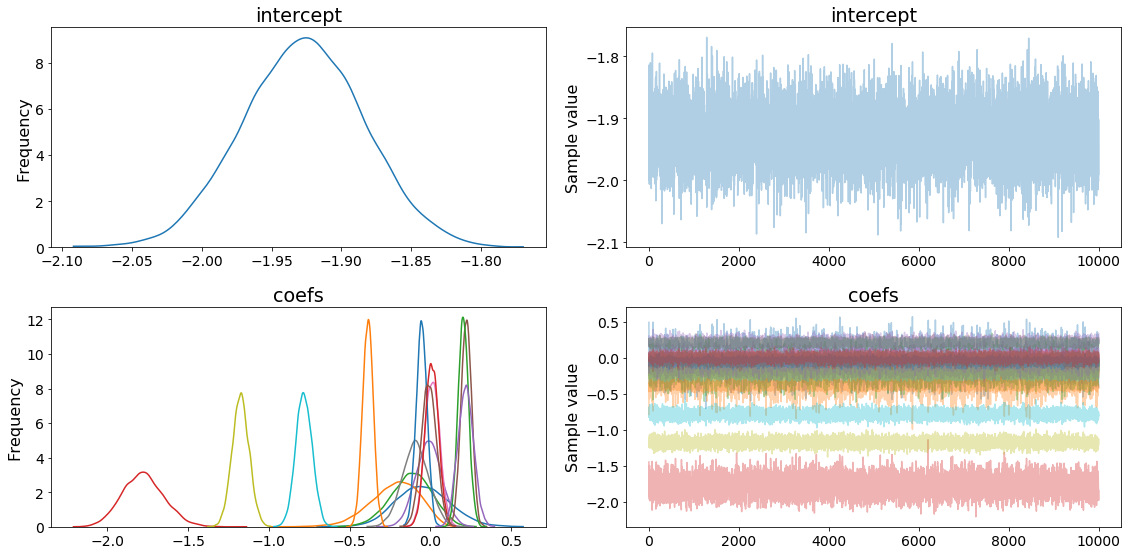

In [120]:
pm.traceplot(trace_m1, figsize=(16, 8));

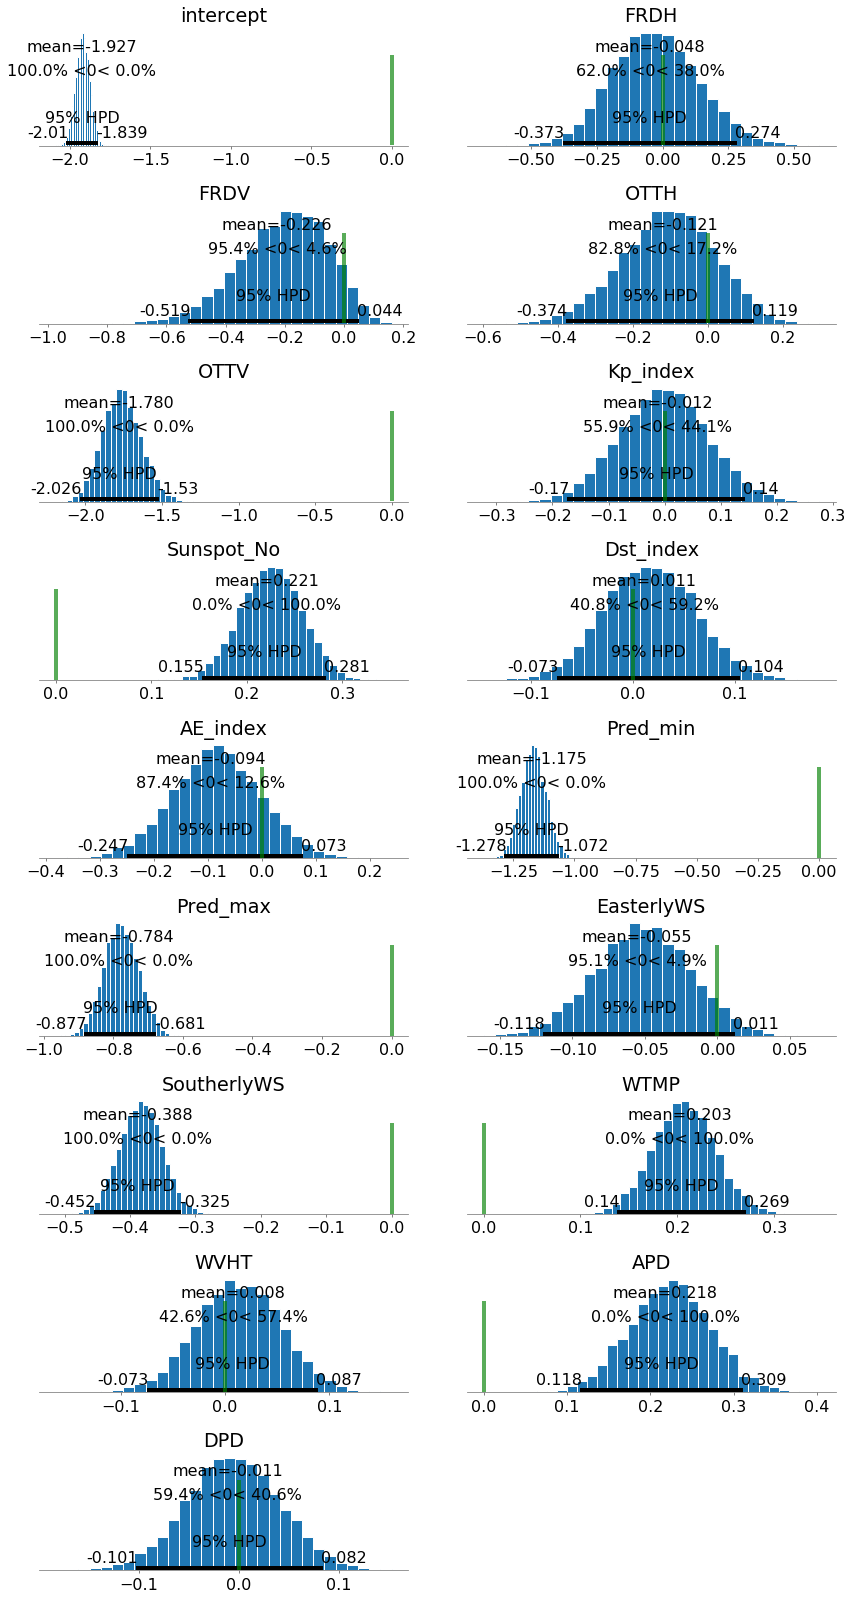

In [121]:
ax = pm.plot_posterior(trace, ref_val=0)
for axi, flbl in zip(ax[1:].ravel(), dfClFeats.columns.tolist()[2:]):
    axi.set_title(flbl)
f = pl.gcf()
f.savefig('../FigJar/Poisson_all.png', format='png', dpi=300)

In [136]:
ppc = pm.sample_ppc(trace_m1, samples=5000, model=m1)
sig95 = pm.hpd(ppc['y_pred'])
med_y_pred = np.median(ppc['y_pred'], axis=0)
idx = np.argsort(y_all_obs)

100%|██████████| 5000/5000 [00:05<00:00, 875.86it/s]


In [137]:
np.var(y_all_obs), np.var(ppc['y_pred'])

(24.248268467305081, 0.39295159836277677)

(0, 50)

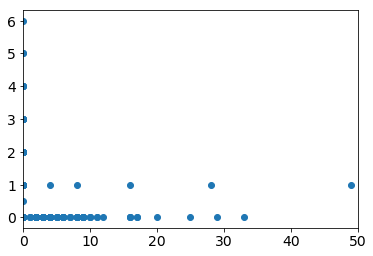

In [141]:
pl.scatter(y_all_obs[idx],med_y_pred[idx])
pl.xlim((0, 50))

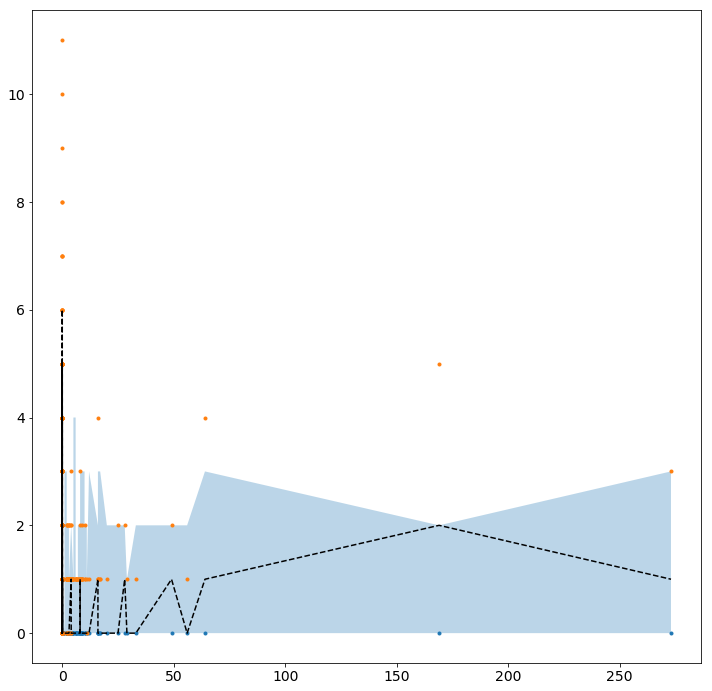

In [138]:
f, ax = pl.subplots( figsize=(12, 12))
ax.plot(y_all_obs[idx], sig95[idx,0], marker='.', ls='')
ax.plot(y_all_obs[idx], sig95[i`dx,1], marker='.', ls='')
ax.plot(y_all_obs[idx], med_y_pred[idx], 'k--')
ax.fill_between(y_all_obs[idx], y1=sig95[:, 0], y2=sig95[:, 1], alpha=0.3)

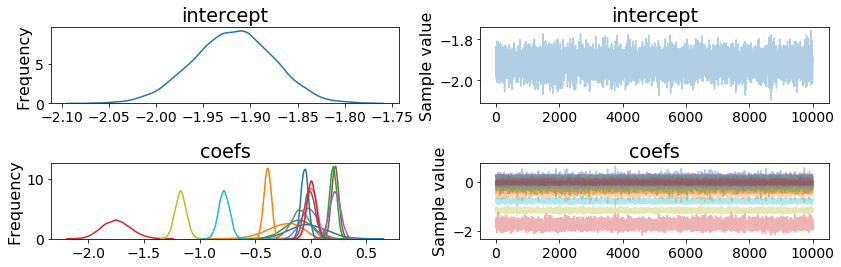

In [143]:
with pm.Model() as m2:
    intercept = pm.Normal('intercept', 0, 1)
    coefs = pm.Normal('coefs', 0, 1, shape=16)
    mu = tt.exp(pm.math.dot(coefs, X_all_sp_s.T) + intercept)
    y_pred = pm.Poisson('y_pred', mu=mu, observed=y_all_obs)
    start = pm.find_MAP()
    trace_m2 = pm.sample(10000, start=start)

pm.traceplot(trace_m2);

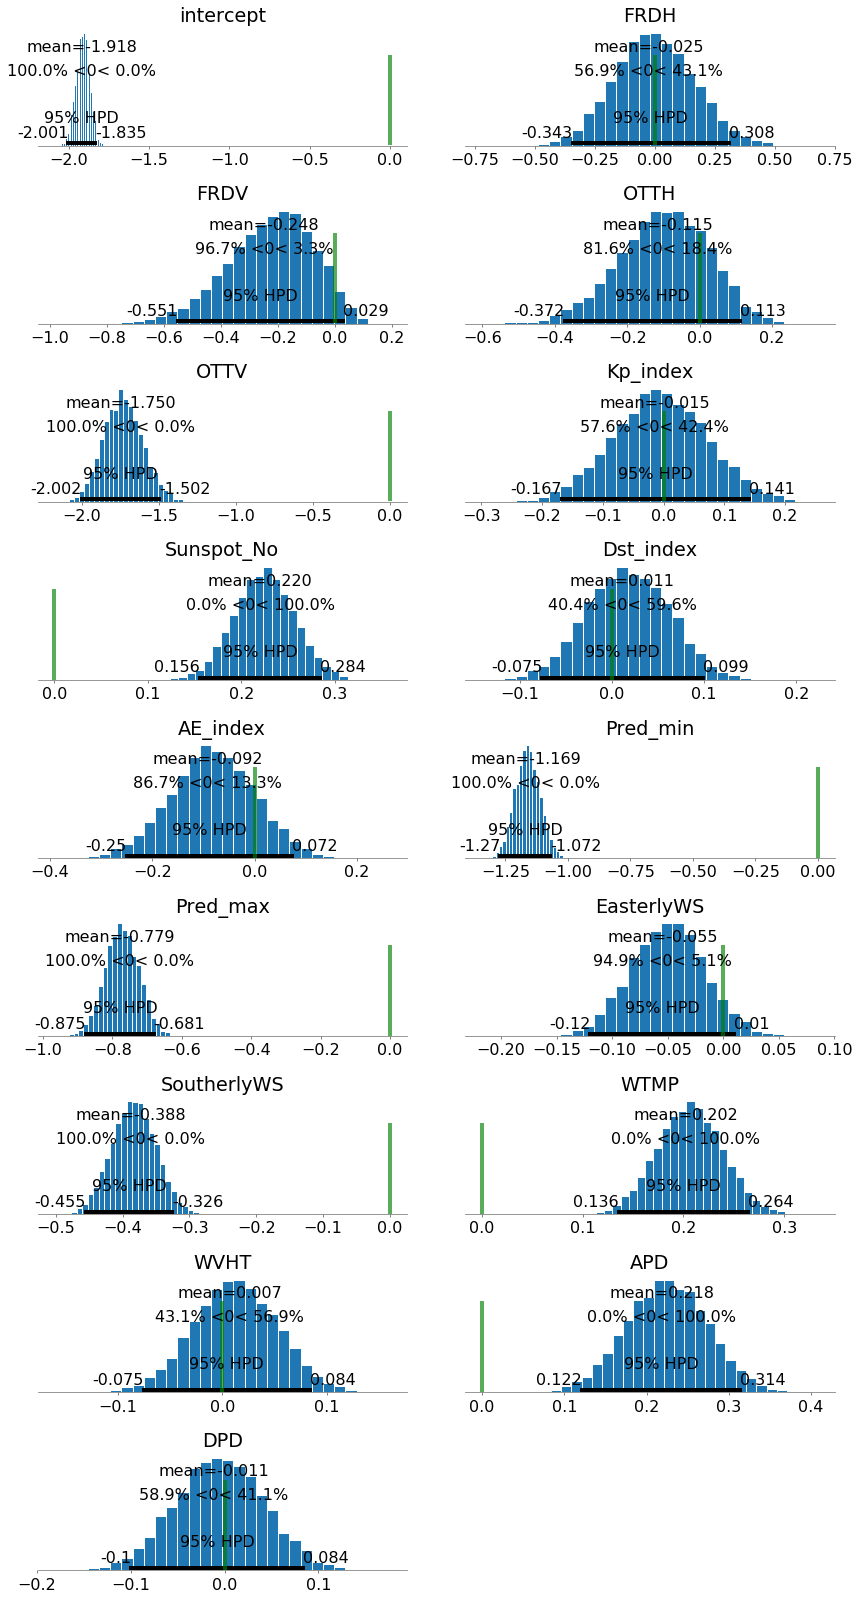

In [144]:
ax = pm.plot_posterior(trace_m2, ref_val=0)
for axi, flbl in zip(ax[1:].ravel(), dfClFeats.columns.tolist()[2:]):
    axi.set_title(flbl)
f = pl.gcf()
f.savefig('../FigJar/Poisson_all_m2_reg.png', format='png', dpi=300)

In [147]:
dfcomp = pm.compare([trace_m0, trace_m1, trace_m2], models=[m0, m1, m2])
dfcomp.index = [['m0', 'm1', 'm2'][i] for i in dfcomp.index]
dfcomp

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
m2,12927.3,791.25,0,NaN,3439.89,0,1
m1,12941.7,797.99,14.4,NaN,3451.59,15.71,1
m0,13174,91.84,246.75,NaN,3961.48,594.58,1


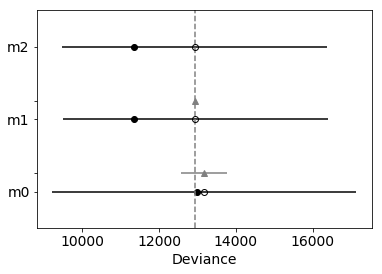

In [148]:
pm.compareplot(dfcomp)